In [ ]:
!fuser -k /dev/nvidia*

In [1]:
!nvidia-smi

Sat Jul 11 02:12:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   40C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!sudo nvidia-persistenced
!sudo nvidia-smi -ac 877,1530

nvidia-persistenced failed to initialize. Check syslog for more details.
Applications clocks set to "(MEM 877, SM 1530)" for GPU 00000000:00:1E.0
All done.


In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:95% !important;}</style>"))

from core import *
from torch_backend import *

colors = ColorMap()
draw = lambda graph: display(DotGraph({p: ({'fillcolor': colors[type(v)], 'tooltip': repr(v)}, inputs) for p, (v, inputs) in graph.items() if v is not None}))

### Network definitions

In [28]:
batch_norm = partial(BatchNorm, weight_init=None, bias_init=None)

In [39]:
help(batch_norm.func)

Help on class BatchNorm in module torch_backend:

class BatchNorm(torch.nn.modules.batchnorm.BatchNorm2d)
 |  Applies Batch Normalization over a 4D input (a mini-batch of 2D inputs
 |  with additional channel dimension) as described in the paper
 |  `Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift`_ .
 |  
 |  .. math::
 |  
 |      y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta
 |  
 |  The mean and standard-deviation are calculated per-dimension over
 |  the mini-batches and :math:`\gamma` and :math:`\beta` are learnable parameter vectors
 |  of size `C` (where `C` is the input size). By default, the elements of :math:`\gamma` are set
 |  to 1 and the elements of :math:`\beta` are set to 0.
 |  
 |  Also by default, during training this layer keeps running estimates of its
 |  computed mean and variance, which are then used for normalization during
 |  evaluation. The running estimates are kept with a def

In [40]:
def res_block(c_in, c_out, stride, **kw):
    block = {
        'bn1': batch_norm(c_in, **kw),
        'relu1': nn.ReLU(True),
        'branch': {
            'conv1': nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False),
            'bn2': batch_norm(c_out, **kw),
            'relu2': nn.ReLU(True),
            'conv2': nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1, bias=False),
        }
    }
    projection = (stride != 1) or (c_in != c_out)    
    if projection:
        block['conv3'] = (nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), ['relu1'])
    block['add'] =  (Add(), [('conv3' if projection else 'relu1'), 'branch/conv2'])
    return block

def DAWN_net(c=64, block=res_block, prep_bn_relu=False, concat_pool=True, **kw):    
    if isinstance(c, int):
        c = [c, 2*c, 4*c, 4*c]
        
    classifier_pool = {
        'in': Identity(),
        'maxpool': nn.MaxPool2d(4),
        'avgpool': (nn.AvgPool2d(4), ['in']),
        'concat': (Concat(), ['maxpool', 'avgpool']),
    } if concat_pool else {'pool': nn.MaxPool2d(4)}
    
    return {
        'input': (None, []),
        'prep': union({'conv': nn.Conv2d(3, c[0], kernel_size=3, stride=1, padding=1, bias=False)},
                      {'bn': batch_norm(c[0], **kw), 'relu': nn.ReLU(True)} if prep_bn_relu else {}),
        'layer1': {
            'block0': block(c[0], c[0], 1, **kw),
            'block1': block(c[0], c[0], 1, **kw),
        },
        'layer2': {
            'block0': block(c[0], c[1], 2, **kw),
            'block1': block(c[1], c[1], 1, **kw),
        },
        'layer3': {
            'block0': block(c[1], c[2], 2, **kw),
            'block1': block(c[2], c[2], 1, **kw),
        },
        'layer4': {
            'block0': block(c[2], c[3], 2, **kw),
            'block1': block(c[3], c[3], 1, **kw),
        },
        'final': union(classifier_pool, {
            'flatten': Flatten(),
            'linear': nn.Linear(2*c[3] if concat_pool else c[3], 10, bias=True),
        }),
        'logits': Identity(),
    }


def conv_bn(c_in, c_out, bn_weight_init=1.0, **kw):
    return {
        'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False),
        # 'bn': batch_norm(c_out, bn_weight_init=bn_weight_init, **kw), 
        'bn': batch_norm(c_out, **kw), 
        'relu': nn.ReLU(True)
    }

def basic_net(channels, weight,  pool, **kw):
    return {
        'input': (None, []),
        'prep': conv_bn(3, channels['prep'], bn_weight_init=1.0, **kw),
        'layer1': dict(conv_bn(channels['prep'], channels['layer1'], **kw), pool=pool),
        'layer2': dict(conv_bn(channels['layer1'], channels['layer2'], **kw), pool=pool),
        'layer3': dict(conv_bn(channels['layer2'], channels['layer3'], **kw), pool=pool),
        'pool': nn.MaxPool2d(4),
        'flatten': Flatten(),
        'linear': nn.Linear(channels['layer3'], 10, bias=False),
        'logits': Mul(weight),
    }

def net(channels=None, weight=0.125, pool=nn.MaxPool2d(2), extra_layers=(), res_layers=('layer1', 'layer3'), **kw):
    channels = channels or {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
    residual = lambda c, **kw: {'in': Identity(), 'res1': conv_bn(c, c, **kw), 'res2': conv_bn(c, c, **kw), 
                                'add': (Add(), ['in', 'res2/relu'])}
    n = basic_net(channels, weight, pool, **kw)
    for layer in res_layers:
        n[layer]['residual'] = residual(channels[layer], **kw)
    for layer in extra_layers:
        n[layer]['extra'] = conv_bn(channels[layer], channels[layer], **kw)       
    return n

remove_identity_nodes = lambda net: remove_by_type(net, Identity)

### Download and preprocess data

In [30]:
DATA_DIR = './data'
dataset = cifar10(DATA_DIR)
timer = Timer()
print('Preprocessing training data')
transforms = [
    partial(normalise, mean=np.array(cifar10_mean, dtype=np.float32), std=np.array(cifar10_std, dtype=np.float32)),
    partial(transpose, source='NHWC', target='NCHW'), 
]
train_set = list(zip(*preprocess(dataset['train'], [partial(pad, border=4)] + transforms).values()))
print(f'Finished in {timer():.2} seconds')
print('Preprocessing test data')
test_set = list(zip(*preprocess(dataset['valid'], transforms).values()))
print(f'Finished in {timer():.2} seconds')

Preprocessing training data
Finished in 1.9 seconds
Preprocessing test data
Finished in 0.09 seconds


### Training loop

In [31]:
def train(model, lr_schedule, train_set, test_set, batch_size, num_workers=0):
    train_batches = DataLoader(train_set, batch_size, shuffle=True, set_random_choices=True, num_workers=num_workers)
    test_batches = DataLoader(test_set, batch_size, shuffle=False, num_workers=num_workers)
    
    lr = lambda step: lr_schedule(step/len(train_batches))/batch_size
    opts = [SGD(trainable_params(model).values(), {'lr': lr, 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)})]
    logs, state = Table(), {MODEL: model, LOSS: x_ent_loss, OPTS: opts}
    for epoch in range(lr_schedule.knots[-1]):
        logs.append(union({'epoch': epoch+1, 'lr': lr_schedule(epoch+1)}, 
                          train_epoch(state, Timer(torch.cuda.synchronize), train_batches, test_batches)))
    return logs

### [Post 1: Baseline](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_1/) - DAWNbench baseline + no initial bn-relu+ efficient dataloading/augmentation, 1 dataloader process (301s)

In [7]:
# 0.9441 -> 7*35=245s
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.1, 0.005, 0])
batch_size = 128

n = DAWN_net()
draw(build_graph(n))
model = Network(n).to(device)
#convert all children including batch norms to half precision (triggering slow codepath!)
for v in model.children(): 
    v.half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=1)

pydot is needed for network visualisation

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.0067       7.4605       1.6552       0.3885       0.5655       1.3325       0.5253       7.4605
           2       0.0133       7.0414       1.0120       0.6403       0.5200       0.9091       0.6753       7.0414
           3       0.0200       7.0356       0.7616       0.7335       0.5337       0.7462       0.7493       7.0356
           4       0.0267       7.0414       0.6519       0.7783       0.5216       0.7672       0.7460       7.0414
           5       0.0333       6.9448       0.5752       0.8021       0.5242       0.6472       0.7908       6.9448
           6       0.0400       6.9234       0.5196       0.8217       0.5291       0.5597       0.8121       6.9234
           7       0.0467       6.9712       0.4681       0.8398       0.5926       0.4525       0.8465       6.9712
           8       0.0533       6.9622       0.4260       0.8532

### [Post 1: Baseline](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_1/) - 0 dataloader processes (297s)

In [8]:
# 0.9401 -> 35 *7
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.1, 0.005, 0])
batch_size = 128

n = DAWN_net()
draw(build_graph(n))
model = Network(n).to(device)
#convert all children including batch norms to half precision (triggering slow codepath!)
for v in model.children(): 
    v.half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

pydot is needed for network visualisation

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.0067       6.7333       1.6723       0.3855       0.4110       1.1889       0.5696       6.7333
           2       0.0133       7.3403       1.0369       0.6286       0.4109       0.9792       0.6627       7.3403
           3       0.0200       7.9121       0.7716       0.7286       0.4050       0.7410       0.7442       7.9121
           4       0.0267       7.6990       0.6505       0.7764       0.4108       0.7791       0.7435       7.6990
           5       0.0333       6.7900       0.5712       0.8060       0.4258       0.6107       0.7886       6.7900
           6       0.0400       7.2001       0.5155       0.8249       0.4135       0.6120       0.7908       7.2001
           7       0.0467       7.1273       0.4710       0.8369       0.4073       0.4822       0.8326       7.1273
           8       0.0533       6.7047       0.4324       0.8511

### [Post 2: Mini-batches](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_2/) - batch size=512 (256s)

In [9]:
# 0.9409 512 35*5=175
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.44, 0.005, 0])
batch_size = 512

n = DAWN_net()
draw(build_graph(n))
model = Network(n).to(device)
#convert all children including batch norms to half precision (triggering slow codepath!)
for v in model.children(): 
    v.half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

pydot is needed for network visualisation

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.0293       6.5629       1.7671       0.3513       0.4458       1.3767       0.5178       6.5629
           2       0.0587       4.9274       1.0808       0.6107       0.3212       1.7736       0.5080       4.9274
           3       0.0880       4.9191       0.8158       0.7141       0.2861       0.9341       0.7011       4.9191
           4       0.1173       4.9248       0.6552       0.7722       0.2869       0.7603       0.7524       4.9248
           5       0.1467       4.9313       0.5688       0.8060       0.2859       0.6299       0.7916       4.9313
           6       0.1760       4.9227       0.4831       0.8345       0.3112       0.5330       0.8171       4.9227
           7       0.2053       4.9299       0.4414       0.8470       0.2863       0.8855       0.7289       4.9299
           8       0.2347       4.9256       0.4024       0.8610

### [Post 3: Regularisation](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_3/) - speed up batch norms (186s)

In [10]:
# .half 半精度 512 35*4.4=154
lr_schedule = PiecewiseLinear([0, 15, 30, 35], [0, 0.44, 0.005, 0])
batch_size = 512

n = DAWN_net()
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR()])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

pydot is needed for network visualisation

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.0293       4.3623       1.7399       0.3580       0.2939       1.2748       0.5400       4.3623
           2       0.0587       4.3687       1.1173       0.5987       0.2936       1.1750       0.6078       4.3687
           3       0.0880       4.3675       0.8360       0.7090       0.2938       0.8180       0.7337       4.3675
           4       0.1173       4.3668       0.6598       0.7732       0.2915       0.6189       0.7910       4.3668
           5       0.1467       4.3773       0.5514       0.8107       0.2917       0.6309       0.7868       4.3773
           6       0.1760       4.3618       0.4897       0.8320       0.2909       0.6280       0.7949       4.3618
           7       0.2053       4.3603       0.4404       0.8483       0.2938       0.6320       0.7832       4.3603
           8       0.2347       4.3614       0.4105       0.8555

### [Post 3: Regularisation](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_3/) - cutout+30 epochs+batch_size=512 (161s)

In [11]:
# 4.36*30=130.8
lr_schedule = PiecewiseLinear([0, 8, 30], [0, 0.4, 0])
batch_size = 512

n = DAWN_net()
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

pydot is needed for network visualisation

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.0500       4.3654       1.7410       0.3651       0.2913       1.3271       0.5247       4.3654
           2       0.1000       4.3668       1.1924       0.5752       0.2911       1.0384       0.6457       4.3668
           3       0.1500       4.3884       0.9033       0.6834       0.2911       0.8674       0.6991       4.3884
           4       0.2000       4.3668       0.7290       0.7453       0.2911       0.7244       0.7509       4.3668
           5       0.2500       4.3661       0.6317       0.7803       0.2913       0.6201       0.7866       4.3661
           6       0.3000       4.3663       0.5699       0.8020       0.2911       0.6264       0.7896       4.3663
           7       0.3500       4.4013       0.5278       0.8189       0.2912       0.6651       0.7794       4.4013
           8       0.4000       4.3663       0.5022       0.8269

### [Post 3: Regularisation](https://www.myrtle.ai/2018/09/24/how_to_train_your_resnet_3/)  - batch_size=768 (154s)

In [12]:
# 768 4.27*30=128.1
# 跳到最后
lr_schedule = PiecewiseLinear([0, 8, 30], [0, 0.6, 0])
batch_size = 768

n = DAWN_net()
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

pydot is needed for network visualisation

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.0750       5.6769       1.8617       0.3316       0.2920       2.1002       0.3935       5.6769
           2       0.1500       4.2685       1.3081       0.5284       0.2912       1.5002       0.5069       4.2685
           3       0.2250       4.2715       0.9973       0.6514       0.3227       4.6497       0.3220       4.2715
           4       0.3000       4.2705       0.7941       0.7245       0.2921       0.8089       0.7274       4.2705
           5       0.3750       4.2728       0.6764       0.7659       0.2918       0.9898       0.6692       4.2728
           6       0.4500       4.2839       0.5953       0.7930       0.2956       1.1169       0.6429       4.2839
           7       0.5250       4.2710       0.5424       0.8120       0.2940       0.7683       0.7378       4.2710
           8       0.6000       4.2888       0.5202       0.8196

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone (36s; test acc 55.9%)

It seems reasonable to study how the shortest path through the network trains in isolation and to take steps to improve this before adding back the longer branches. 
Eliminating the long branches yields the following backbone network in which all convolutions, except for the initial one, have a stride of two.

Training the shortest path network for 20 epochs yields an unimpressive test accuracy of 55.9% in 36 seconds.

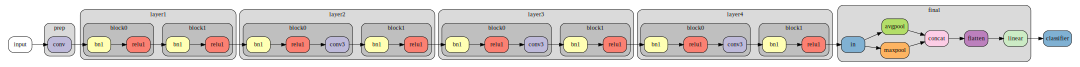

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       1.8775       1.9952       0.2584       0.1548       1.7645       0.3561       2.0323
           2       0.2000       1.8689       1.7656       0.3524       0.1450       1.6898       0.3839       4.0462
           3       0.3000       1.8307       1.6943       0.3821       0.1550       1.6774       0.3876       6.0319
           4       0.4000       1.8995       1.6663       0.3929       0.1440       1.5992       0.4225       8.0755
           5       0.3750       1.7525       1.6494       0.4032       0.1564       1.5825       0.4284       9.9843
           6       0.3500       1.8375       1.6126       0.4125       0.1465       1.5598       0.4356      11.9684
           7       0.3250       1.7787       1.5944       0.4254       0.1567       1.6138       0.4260      13.9037
           8       0.3000       1.9086       1.5611       0.4361

In [20]:
def shortcut_block(c_in, c_out, stride, **kw):
    block = {
        'bn1': batch_norm(c_in, **kw),
        'relu1': nn.ReLU(True),
    }
    projection = (stride != 1) or (c_in != c_out)    
    if projection:
        block['conv3'] = (nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), ['relu1'])
    return block

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block)
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, remove repeat bn-relu (32s; test acc 56.0%)

Removing the repeated batch norm-ReLU groups, reduces training time to 32s and leaves test accuracy approximately unchanged.

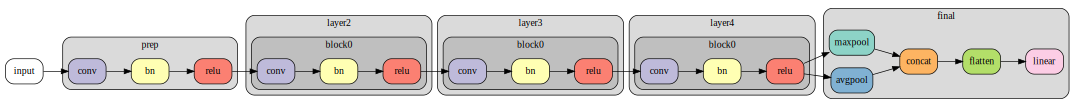

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       2.0275       1.9549       0.2788       0.1974       1.7310       0.3777       2.2249
           2       0.2000       1.6905       1.7492       0.3624       0.1465       1.6506       0.3997       4.0619
           3       0.3000       1.6741       1.6697       0.3913       0.1418       1.6870       0.3864       5.8779
           4       0.4000       1.7245       1.6648       0.3987       0.1441       1.6405       0.4068       7.7464
           5       0.3750       1.5438       1.6470       0.4054       0.1373       1.5562       0.4478       9.4275
           6       0.3500       1.5782       1.6121       0.4199       0.1462       1.5877       0.4286      11.1519
           7       0.3250       1.6797       1.5869       0.4275       0.1476       1.5179       0.4499      12.9793
           8       0.3000       1.7134       1.5592       0.4379

In [5]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv':  nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, padding=0, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
        }
    else:
        return {'id': Identity()}

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block, prep_bn_relu=True)
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, 3x3 convs (36s; test acc 85.6%)

A serious shortcoming of this network is that the downsampling convolutions have 1x1 kernels and a stride of two, so that rather than enlarging the receptive field they are simply discarding information. 

If we replace these with 3x3 convolutions, things improve considerably and test accuracy after 20 epochs is 85.6% in a time of 36s.

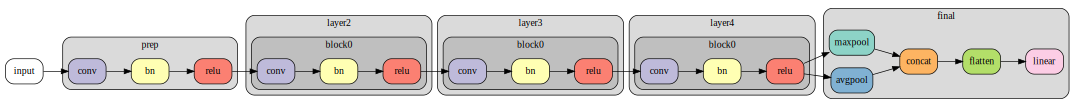

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       2.0508       1.7308       0.3705       0.1861       1.3731       0.4903       2.2369
           2       0.2000       1.5441       1.3386       0.5154       0.1478       1.1711       0.5787       3.9288
           3       0.3000       1.7685       1.1407       0.5904       0.1450       1.0622       0.6204       5.8424
           4       0.4000       1.6975       1.0908       0.6144       0.1506       1.0718       0.6245       7.6905
           5       0.3750       1.7146       1.0078       0.6450       0.1492       0.9757       0.6593       9.5543
           6       0.3500       1.6656       0.9080       0.6802       0.1534       0.8884       0.6895      11.3733
           7       0.3250       1.7620       0.8637       0.6964       0.1456       0.9482       0.6865      13.2808
           8       0.3000       1.5897       0.7945       0.7212

In [6]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
        }
    else:
        return {'id': Identity()}

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block, prep_bn_relu=True)
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, maxpool downsampling (43s; test acc 89.7%)

We can further improve the downsampling stages by applying 3x3 convolutions of stride one followed by a pooling layer instead of using strided convolutions. 

We choose max pooling with a 2x2 window size leading to a final test accuracy of 89.7% after 43s. Using average pooling gives a similar result but takes slightly longer.

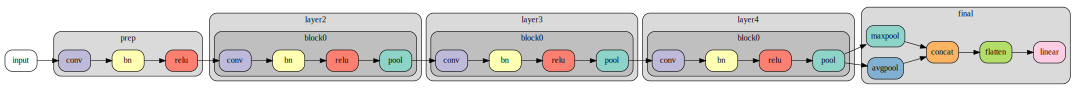

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.1000       3.0536       1.6871       0.3949       0.2558       1.3948       0.5405       3.3093
           2       0.2000       1.8671       1.1606       0.5894       0.1508       0.9039       0.6839       5.3273
           3       0.3000       1.9303       0.9527       0.6686       0.1573       1.0704       0.6257       7.4150
           4       0.4000       1.8663       0.8934       0.6901       0.1485       0.8327       0.7113       9.4297
           5       0.3750       1.8682       0.8073       0.7195       0.1412       0.7715       0.7316      11.4391
           6       0.3500       1.8614       0.7249       0.7520       0.1484       0.6337       0.7838      13.4489
           7       0.3250       1.9188       0.6648       0.7700       0.1519       0.7069       0.7600      15.5196
           8       0.3000       1.8644       0.6291       0.7826

In [7]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
            'pool': nn.MaxPool2d(2),
        }
    else:
        return {'id': Identity()}

lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(block=shortcut_block, prep_bn_relu=True)
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, 2x output dim, global maxpool (47s; test acc 90.7%)

The final pooling layer before the classifier is a concatenation of global average pooling and max pooling layers, inherited from the original network. 

We replace this with a more standard global max pooling layer and double the output dimension of the final convolution to compensate for the reduction in input dimension to the classifier, leading to a final test accuracy of 90.7% in 47s. Note that average pooling at this stage underperforms max pooling significantly.


In [15]:
def shortcut_block(c_in, c_out, stride, **kw):
    projection = (stride != 1) or (c_in != c_out)
    if projection:
        return {
            'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
            'bn': batch_norm(c_out, **kw),
            'relu': nn.ReLU(True),
            'pool': nn.MaxPool2d(2),
        }
    else:
        return {'id': Identity()}

In [14]:
# 2.2 * 20 =44
lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = DAWN_net(c=[64,128,256,512], block=shortcut_block, prep_bn_relu=True, concat_pool=False)
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

pydot is needed for network visualisation

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.1000       3.5737       2.5182       0.2611       0.2705       1.7183       0.3570       3.5737
           2       0.2000       2.2277       1.5747       0.4348       0.1406       1.2078       0.5664       2.2277
           3       0.3000       2.2044       1.2050       0.5728       0.1407       1.1565       0.5769       2.2044
           4       0.4000       2.2073       1.0124       0.6436       0.1407       0.9111       0.6810       2.2073
           5       0.3750       2.2311       0.8737       0.6981       0.1408       0.7917       0.7319       2.2311
           6       0.3500       2.2578       0.7357       0.7472       0.1439       0.8536       0.7169       2.2578
           7       0.3250       2.2318       0.6640       0.7698       0.1407       0.9673       0.6843       2.2318
           8       0.3000       2.2446       0.6117       0.7892

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - backbone, bn scale init=1, classifier weight=0.125 (47s; test acc 91.1%)

By default in PyTorch (0.4), initial batch norm scales are chosen uniformly at random from the interval [0,1]. Channels which are initialised near zero could be wasted so we replace this with a constant initialisation at 1. 
This leads to a larger signal through the network and to compensate we introduce an overall constant multiplicative rescaling of the final classifier. A rough manual optimisation of this extra hyperparameter suggest that 0.125 is a reasonable value. 
(The low value makes predictions less certain and appears to ease optimisation.) 

With these changes in place, 20 epoch training reaches a test accuracy of 91.1% in 47s. 

In [17]:
# classifier weight=0.125
lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = net(extra_layers=(), res_layers=())
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

TypeError: __init__() got an unexpected keyword argument 'bn_weight_init'

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - double width, 60 epoch train! (321s; test acc 93.5%)

ne approach that doesn't seem particularly promising is to just add width. 

If we double the channel dimensions and train for 60 epochs we can reach 93.5% test accuracy with a 5 layer network. This is nice but not efficient since training now takes 321s.

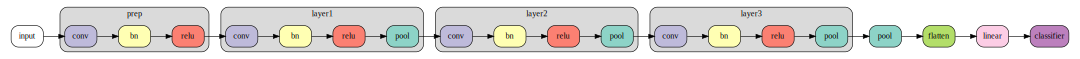

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0333       9.6687       1.8879       0.3291       0.7929       1.6214       0.4464      10.4616
           2       0.0667       5.3167       1.2460       0.5628       0.3784       1.0503       0.6263      16.1567
           3       0.1000       5.3180       0.9350       0.6807       0.3807       0.7622       0.7368      21.8554
           4       0.1333       5.3191       0.7673       0.7385       0.3788       0.7431       0.7427      27.5533
           5       0.1667       5.3328       0.6730       0.7719       0.3793       0.7541       0.7432      33.2654
           6       0.2000       5.3204       0.6109       0.7939       0.3790       0.5805       0.8037      38.9648
           7       0.2333       5.3206       0.5681       0.8102       0.3781       0.5228       0.8300      44.6635
           8       0.2667       5.3186       0.5294       0.8226

In [10]:
lr_schedule = PiecewiseLinear([0, 12, 60], [0, 0.4, 0])
batch_size = 512
c = 128

n = net(channels={'prep': c, 'layer1': 2*c, 'layer2': 4*c, 'layer3': 8*c}, extra_layers=(), res_layers=())
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - extra:L1+L2+L3 network, 60 epochs, cutout=12 (180s, 95.0% test acc) 

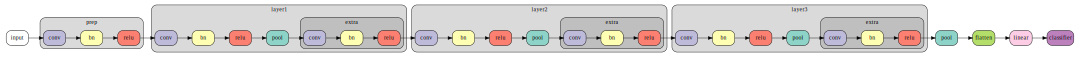

       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0333       3.4445       1.8571       0.3390       0.2635       1.6723       0.4054       3.7080
           2       0.0667       2.6818       1.1796       0.5765       0.1940       0.9478       0.6556       6.5838
           3       0.1000       2.7352       0.8991       0.6836       0.1946       1.2571       0.6007       9.5136
           4       0.1333       2.6792       0.7638       0.7338       0.1938       0.6789       0.7684      12.3865
           5       0.1667       2.6790       0.6880       0.7593       0.1942       0.6666       0.7731      15.2597
           6       0.2000       2.6813       0.6320       0.7809       0.1942       0.6575       0.7732      18.1352
           7       0.2333       2.7264       0.5933       0.7934       0.1947       0.7307       0.7545      21.0562
           8       0.2667       2.6791       0.5655       0.8046

In [13]:
lr_schedule = PiecewiseLinear([0, 12, 60], [0, 0.4, 0])
batch_size = 512
cutout=12

n = net(extra_layers=['layer1', 'layer2', 'layer3'], res_layers=())
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(cutout, cutout)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - final network Residual:L1+L3, 20 epochs (66s; test acc 93.7%)

In [32]:
lr_schedule = PiecewiseLinear([0, 4, 20], [0, 0.4, 0])
batch_size = 512

n = net()
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

TypeError: __init__() got an unexpected keyword argument 'bn_weight_init'

### [Post 4: Architecture](https://www.myrtle.ai/2018/10/26/how_to_train_your_resnet_4/)  - final network, 24 epochs (79s; test acc 94.1%)

In [41]:
# 改完结构之后 3.15*24=75.6
lr_schedule = PiecewiseLinear([0, 5, 24], [0, 0.4, 0])
batch_size = 512

n = net()
draw(build_graph(n))
model = Network(n).to(device).half()
train_set_x = Transform(train_set, [Crop(32, 32), FlipLR(), Cutout(8,8)])
summary = train(model, lr_schedule, train_set_x, test_set, batch_size=batch_size, num_workers=0)

pydot is needed for network visualisation

       epoch           lr   train time   train loss    train acc   valid time   valid loss    valid acc   total time
           1       0.0800       3.6476       1.6487       0.4056       0.2773       1.0957       0.6029       3.6476
           2       0.1600       3.1836       0.9394       0.6645       0.2139       0.7842       0.7202       3.1836
           3       0.2400       3.1422       0.7317       0.7430       0.2139       0.7597       0.7444       3.1422
           4       0.3200       3.1384       0.6271       0.7811       0.2137       0.6439       0.7878       3.1384
           5       0.4000       3.1458       0.5575       0.8078       0.2146       0.8910       0.6983       3.1458
           6       0.3789       3.1649       0.4963       0.8286       0.2144       0.6528       0.7783       3.1649
           7       0.3579       3.1392       0.4452       0.8475       0.2137       0.5258       0.8222       3.1392
           8       0.3368       3.1395       0.4093       0.8601